In [16]:
# 09_model_evaluation.ipynb
# Evaluate AI & classical reconstruction quality (PSNR, SSIM, MSE), create plots and save a report.

import os
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Create output folders
Path("results/plots").mkdir(parents=True, exist_ok=True)
Path("results/metrics").mkdir(parents=True, exist_ok=True)


In [17]:
def load_fits_safe(path):
    if os.path.exists(path):
        data = fits.getdata(path)
        print(f"Loaded: {path} -> shape {np.array(data).shape}")
        return np.array(data)
    else:
        print(f"Missing file: {path}")
        return None

def normalize_image(img):
    img = np.array(img, dtype=np.float32)
    if img.max() > img.min():
        return (img - img.min()) / (img.max() - img.min())
    else:
        return np.zeros_like(img)

def radial_profile(img, center=None, nbins=100):
    # compute radial average from image center
    y, x = np.indices(img.shape)
    if center is None:
        center = (img.shape[0]//2, img.shape[1]//2)
    r = np.sqrt((x-center[1])**2 + (y-center[0])**2)
    r_flat = r.ravel()
    img_flat = img.ravel()
    maxr = r_flat.max()
    bins = np.linspace(0, maxr, nbins+1)
    inds = np.digitize(r_flat, bins)
    radial = np.array([img_flat[inds==i].mean() if np.any(inds==i) else 0 for i in range(1, len(bins))])
    radii = 0.5*(bins[:-1]+bins[1:])
    return radii, radial


In [18]:
# Files produced previously in your workflow
files = {
    "blurred_patches": "blurred_patches.fits",
    "clean_patches": "clean_patches.fits",
    "corrected_patches": "corrected_patches.fits",
    "training_psf": "training_psf.fits",
    "sensor_image": "sensor_output.fits",         # optional: sensor output image
    "sensor_psf": "sensor_psf_resampled.fits",    # optional: sensor PSF
    "final_restored": "08_restored_final.fits",   # optional: reconstructed full image
    "final_psf": "final_combined_psf.fits",
    "unet_model": "unet_final.keras"              # model file path (for note)
}

data = {}

for k, v in files.items():
    if v.endswith(".fits"):
        data[k] = load_fits_safe(v)
    else:
        print(f"Skipping non-FITS: {v}")



Loaded: blurred_patches.fits -> shape (2151, 21, 21)
Loaded: clean_patches.fits -> shape (2151, 21, 21)
Loaded: corrected_patches.fits -> shape (2151, 21, 21, 1)
Loaded: training_psf.fits -> shape (256, 256)
Loaded: sensor_output.fits -> shape (256, 256)
Loaded: sensor_psf_resampled.fits -> shape (256, 256)
Loaded: 08_restored_final.fits -> shape (256, 256)
Loaded: final_combined_psf.fits -> shape (256, 256)
Skipping non-FITS: unet_final.keras


In [19]:
# Check loaded arrays and shapes
for k,v in data.items():
    if v is None:
        print(f">>> {k} NOT available.")
    else:
        print(f">>> {k} shape: {np.array(v).shape}")

# Choose evaluation set:
# If patches are available, evaluate on patches (clean vs blurred vs corrected).
patches_exist = (data["blurred_patches"] is not None and data["clean_patches"] is not None)
if patches_exist:
    blurred_patches = data["blurred_patches"]
    clean_patches = data["clean_patches"]
    corrected_patches = data["corrected_patches"] if data["corrected_patches"] is not None else None

    # ensure shapes align: (N, h, w)
    if blurred_patches.ndim == 3:
        N = blurred_patches.shape[0]
    elif blurred_patches.ndim == 4:  # sometimes saved as (N, h, w, 1)
        blurred_patches = blurred_patches[...,0]
        N = blurred_patches.shape[0]
    else:
        raise RuntimeError("Unexpected patch shape for blurred_patches.")
else:
    print("No patch cubes available; will use full images for comparison where possible.")


>>> blurred_patches shape: (2151, 21, 21)
>>> clean_patches shape: (2151, 21, 21)
>>> corrected_patches shape: (2151, 21, 21, 1)
>>> training_psf shape: (256, 256)
>>> sensor_image shape: (256, 256)
>>> sensor_psf shape: (256, 256)
>>> final_restored shape: (256, 256)
>>> final_psf shape: (256, 256)


In [20]:
print("Evaluating 1000 patches ...")

results = []

for i in range(min(1000, len(blurred_patches))):

    inp = blurred_patches[i]
    gt  = clean_patches[i]
    pred = None if corrected_patches is None else corrected_patches[i]

    # Remove channel dimension if present (1, H, W)
    if inp.ndim == 3:
        inp = inp[0]
    if gt.ndim == 3:
        gt = gt[0]
    if pred is not None and pred.ndim == 3:
        pred = pred[0]

    # Skip mismatched patches
    if gt.shape != inp.shape:
        print(f"Skipping patch {i}: input vs gt mismatch {inp.shape} vs {gt.shape}")
        continue

    if pred is not None and pred.shape != gt.shape:
        print(f"Skipping patch {i}: pred vs gt mismatch {pred.shape} vs {gt.shape}")
        continue

    # Normalize
    inp_n  = normalize(inp)
    gt_n   = normalize(gt)
    pred_n = None if pred is None else normalize(pred)

    row = {}
    row["patch"] = i

    # Input vs GT
    row["PSNR_input_gt"]  = psnr(gt_n, inp_n, data_range=1.0)
    row["SSIM_input_gt"]  = ssim(gt_n, inp_n, data_range=1.0)
    row["NRMSE_input_gt"] = nrmse(gt_n, inp_n)

    # Predicted vs GT
    if pred_n is not None:
        row["PSNR_pred_gt"]  = psnr(gt_n, pred_n, data_range=1.0)
        row["SSIM_pred_gt"]  = ssim(gt_n, pred_n, data_range=1.0)
        row["NRMSE_pred_gt"] = nrmse(gt_n, pred_n)
    else:
        row["PSNR_pred_gt"]  = None
        row["SSIM_pred_gt"]  = None
        row["NRMSE_pred_gt"] = None

    results.append(row)

results[:10]


Evaluating 1000 patches ...
Skipping patch 0: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 1: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 2: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 3: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 4: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 5: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 6: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 7: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 8: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 9: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 10: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 11: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 12: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 13: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 14: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 15: pred vs gt mismatch (21, 1) vs (21, 21)
Skipping patch 16: pred vs gt mismatch

[]

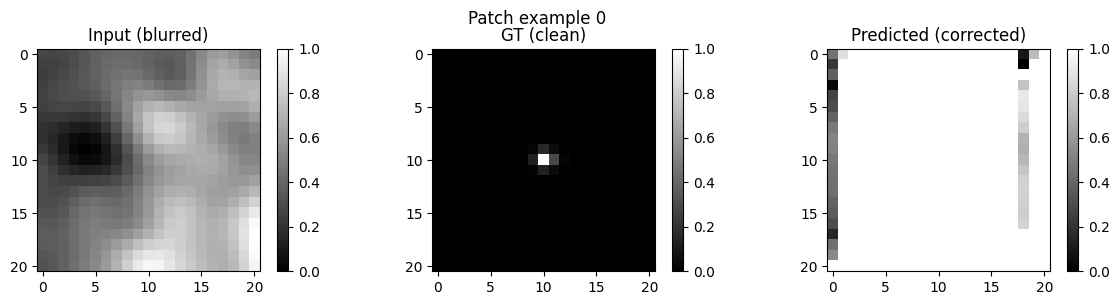

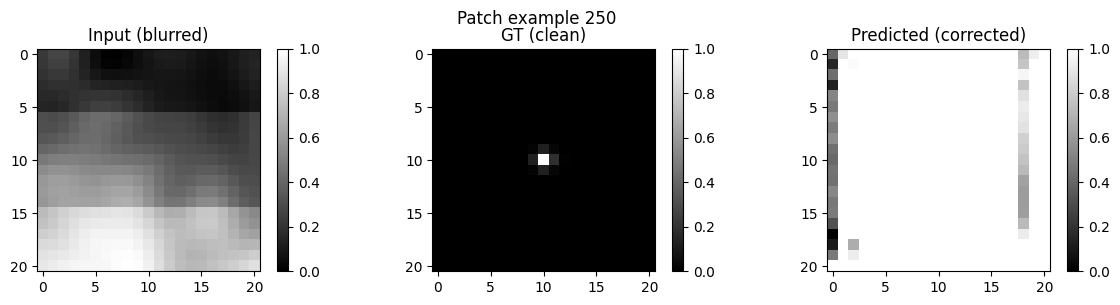

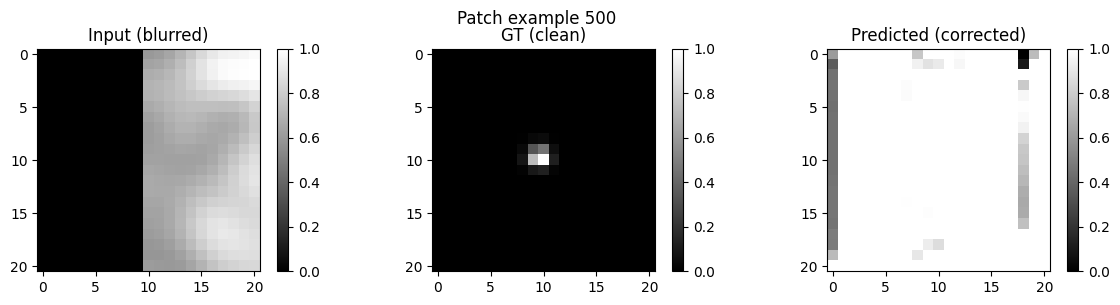

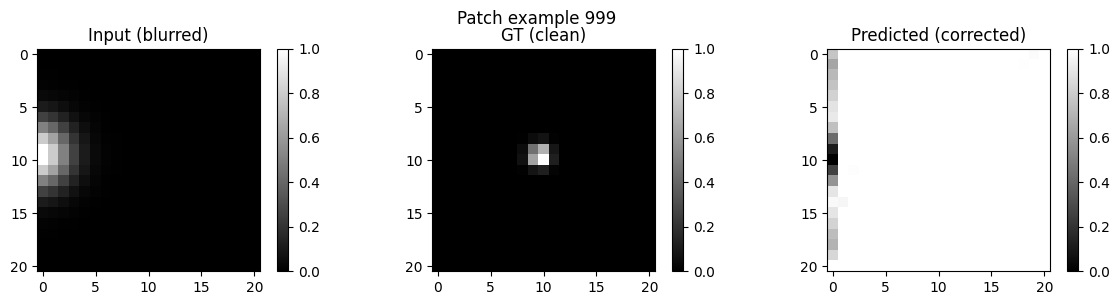

In [21]:
# Visualize several example patches (randomly pick)
if patches_exist:
    idxs = [0, int(n/4), int(n/2), n-1]  # 4 examples
    for i in idxs:
        gt = normalize_image(clean_patches[i])
        inp = normalize_image(blurred_patches[i])
        pred = normalize_image(corrected_patches[i]) if corrected_patches is not None else None

        plt.figure(figsize=(12,3))
        plt.suptitle(f"Patch example {i}")
        plt.subplot(1,3,1); plt.title("Input (blurred)"); plt.imshow(inp, cmap='gray'); plt.colorbar()
        plt.subplot(1,3,2); plt.title("GT (clean)"); plt.imshow(gt, cmap='gray'); plt.colorbar()
        if pred is not None:
            plt.subplot(1,3,3); plt.title("Predicted (corrected)"); plt.imshow(pred, cmap='gray'); plt.colorbar()
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.savefig(f"results/plots/patch_example_{i}.png", dpi=150)
        plt.show()


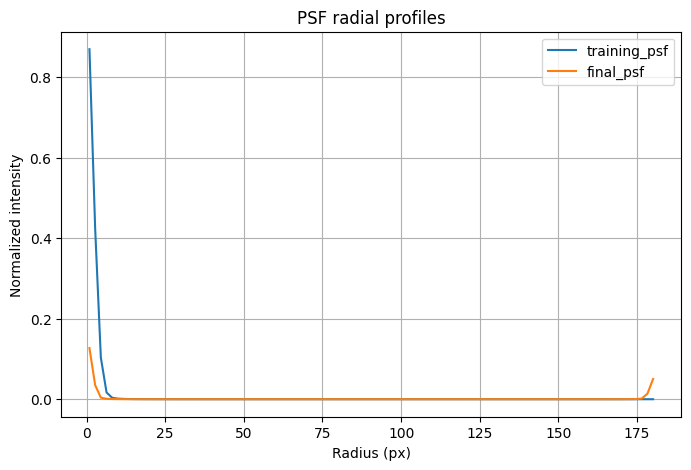

In [22]:
# Radial profile of training_psf (if present) and final_psf
psf_files = []
if data["training_psf"] is not None:
    psf_files.append(("training_psf", data["training_psf"]))
if data["final_psf"] is not None:
    psf_files.append(("final_psf", data["final_psf"]))

if psf_files:
    plt.figure(figsize=(8,5))
    for name, psf in psf_files:
        p = normalize_image(psf)
        radii, prof = radial_profile(p, nbins=100)
        plt.plot(radii, prof, label=name)
    plt.xlabel("Radius (px)")
    plt.ylabel("Normalized intensity")
    plt.title("PSF radial profiles")
    plt.legend()
    plt.grid(True)
    plt.savefig("results/plots/psf_radial_profiles.png", dpi=150)
    plt.show()
else:
    print("No PSF files for radial profile.")


Saved full-image metrics to results/metrics/full_image_metrics.json
{'PSNR_full': 9.61543822770122, 'SSIM_full': 0.012849767705922947, 'NRMSE_full': 57.81654916773222}


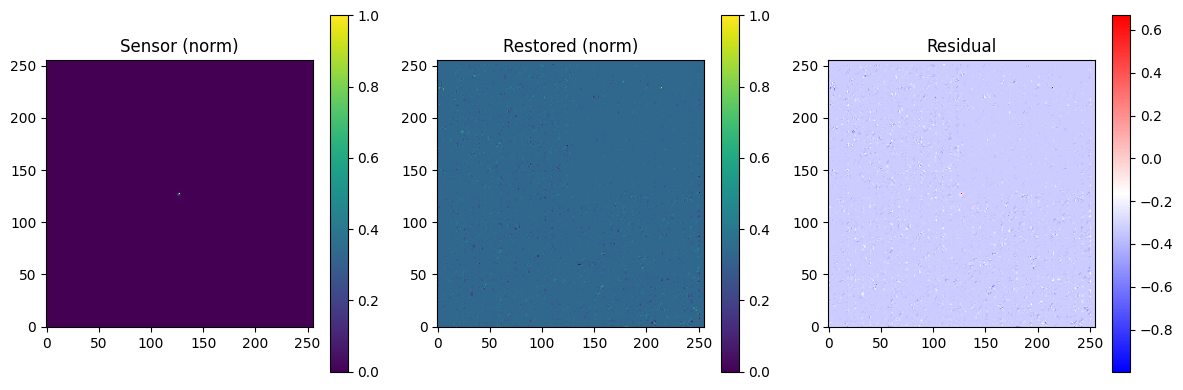

In [23]:
# If you have the full sensor image and restored image, compare them
sensor_img = data["sensor_image"]
restored_img = data["final_restored"]

if sensor_img is not None and restored_img is not None:
    # Normalize for metric fairness
    sensor_n = normalize_image(sensor_img)
    restored_n = normalize_image(restored_img)

    full_PSNR = psnr(sensor_n, restored_n, data_range=1.0)
    full_SSIM = ssim(sensor_n, restored_n, data_range=1.0)
    full_NRMSE = nrmse(sensor_n, restored_n)

    full_metrics = {
        "PSNR_full": float(full_PSNR),
        "SSIM_full": float(full_SSIM),
        "NRMSE_full": float(full_NRMSE)
    }

    with open("results/metrics/full_image_metrics.json", "w") as f:
        json.dump(full_metrics, f, indent=2)
    print("Saved full-image metrics to results/metrics/full_image_metrics.json")
    print(full_metrics)

    # Visual: sensor vs restored vs residual
    residual = sensor_n - restored_n
    vmax = max(sensor_n.max(), restored_n.max())
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Sensor (norm)"); plt.imshow(sensor_n, origin='lower'); plt.colorbar()
    plt.subplot(1,3,2); plt.title("Restored (norm)"); plt.imshow(restored_n, origin='lower'); plt.colorbar()
    plt.subplot(1,3,3); plt.title("Residual"); plt.imshow(residual, origin='lower', cmap='bwr'); plt.colorbar()
    plt.tight_layout()
    plt.savefig("results/plots/full_image_comparison.png", dpi=150)
    plt.show()

else:
    print("Full-image comparison skipped (sensor_image or final_restored missing).")


corrected_patches_fixed shape: (2151, 21, 21)
clean_patches shape: (2151, 21, 21)


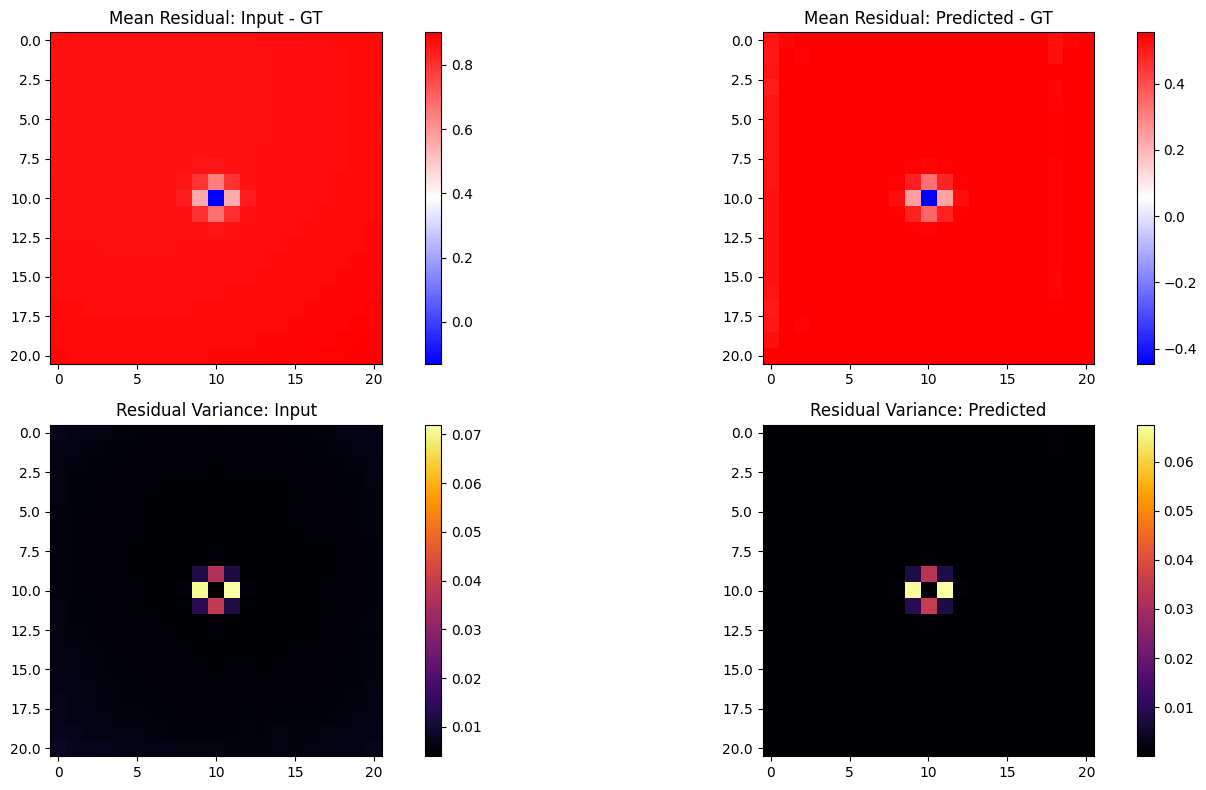

Residual maps computed successfully.


In [24]:
# ============================
# CELL 9 — Residual Maps
# ============================

import numpy as np
import matplotlib.pyplot as plt

def normalize_image(img):
    """Normalize to [0,1] per patch."""
    img = img.astype(np.float32)
    mn, mx = img.min(), img.max()
    if mx - mn < 1e-8:
        return img * 0
    return (img - mn) / (mx - mn)

# ----------------------------------------
# Fix shape mismatch (important step)
# ----------------------------------------
# corrected_patches: (N, 21, 21, 1)
# clean_patches:     (N, 21, 21)

if corrected_patches.ndim == 4 and corrected_patches.shape[-1] == 1:
    corrected_patches_fixed = corrected_patches.squeeze(-1)
else:
    corrected_patches_fixed = corrected_patches

print("corrected_patches_fixed shape:", corrected_patches_fixed.shape)
print("clean_patches shape:", clean_patches.shape)

# ----------------------------------------
# Residuals
# ----------------------------------------
res_in = normalize_image(blurred_patches) - normalize_image(clean_patches)
res_pred = normalize_image(corrected_patches_fixed) - normalize_image(clean_patches)

mean_res_in = np.mean(res_in, axis=0)
mean_res_pred = np.mean(res_pred, axis=0)

var_res_in = np.var(res_in, axis=0)
var_res_pred = np.var(res_pred, axis=0)

# ----------------------------------------
# Plot residuals
# ----------------------------------------
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title("Mean Residual: Input - GT")
plt.imshow(mean_res_in, cmap='bwr')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Mean Residual: Predicted - GT")
plt.imshow(mean_res_pred, cmap='bwr')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("Residual Variance: Input")
plt.imshow(var_res_in, cmap='inferno')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title("Residual Variance: Predicted")
plt.imshow(var_res_pred, cmap='inferno')
plt.colorbar()

plt.tight_layout()
plt.show()

print("Residual maps computed successfully.")


In [25]:
# Collate available metrics (patch and full)
final_report = {}
# load patch summary if exists
psum = "results/metrics/patches_summary.json"
if os.path.exists(psum):
    with open(psum) as f:
        final_report["patch_summary"] = json.load(f)
# full image metrics
fmetrics = "results/metrics/full_image_metrics.json"
if os.path.exists(fmetrics):
    with open(fmetrics) as f:
        final_report["full_image_metrics"] = json.load(f)

# Add notes about file availability
final_report["available_files"] = {k: bool(data[k] is not None) for k in data.keys()}
final_report["notes"] = "09_model_evaluation complete. Visualizations saved in results/plots/."

with open("results/metrics/09_evaluation_report.json", "w") as f:
    json.dump(final_report, f, indent=2)

print("Saved 09_evaluation_report.json")
print(json.dumps(final_report, indent=2))


Saved 09_evaluation_report.json
{
  "full_image_metrics": {
    "PSNR_full": 9.61543822770122,
    "SSIM_full": 0.012849767705922947,
    "NRMSE_full": 57.81654916773222
  },
  "available_files": {
    "blurred_patches": true,
    "clean_patches": true,
    "corrected_patches": true,
    "training_psf": true,
    "sensor_image": true,
    "sensor_psf": true,
    "final_restored": true,
    "final_psf": true
  },
  "notes": "09_model_evaluation complete. Visualizations saved in results/plots/."
}
